# Map-Reduced AIS Clustering

This notebook mirrors the `AISDatasetBase` / `make_ais_dataset` workflow used in `src/train/train_traj_V3.py` and `src/utils/datasets_V3.py`.
It loads the map-reduced pickled trajectories from `data/map_reduced/{train,val,test}` and gathers latitude/longitude
observations so we can experiment with simple K-means clustering, elbow heuristics, and Voronoi visualizations.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.spatial import Voronoi, voronoi_plot_2d
import sys

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise RuntimeError('Cannot locate project root (missing src/).')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_ROOT = PROJECT_ROOT / 'data' / 'map_reduced'
print(f'Project root: {PROJECT_ROOT}')
print(f'Data root: {DATA_ROOT}')


Project root: D:\DTU\AIS-MDA
Data root: D:\DTU\AIS-MDA\data\map_reduced


In [3]:
from src.utils.datasets import AISDatasetBase

MAX_SEQLEN = 128
datasets = {}
for split in ('train', 'val', 'test'):
    split_dir = DATA_ROOT / split
    if not split_dir.exists():
        raise FileNotFoundError(f'Missing directory: {split_dir}')
    datasets[split] = AISDatasetBase(str(split_dir), max_seqlen=MAX_SEQLEN)
    print(f"{split}: {len(datasets[split])} pickles loaded")


[AISDataset] Scanning 3010 files. Mode=head, Oversample=1x
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
train: 3010 pickles loaded
[AISDataset] Scanning 377 files. Mode=head, Oversample=1x
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
val: 377 pickles loaded
[AISDataset] Scanning 374 files. Mode=head, Oversample=1x
[AISDataset] Building start-index lookup tables...
[AISDataset] Metadata ready.
test: 374 pickles loaded


In [4]:
def gather_lat_lon(dataset, max_sequences=400):
    coords = []
    upper = min(len(dataset), max_sequences)
    for idx in range(upper):
        seq, mask, seqlen, *_ = dataset[idx]
        seqlen = int(seqlen.item())
        coords.append(seq[:seqlen, :2].numpy())
    if not coords:
        return np.empty((0, 2))
    stacked = np.concatenate(coords, axis=0)
    print(f'Collected {stacked.shape[0]} coords from {upper} sequences')
    return stacked

train_coords = gather_lat_lon(datasets['train'])
val_coords = gather_lat_lon(datasets['val'])
test_coords = gather_lat_lon(datasets['test'])


Collected 46068 coords from 400 sequences
Collected 44000 coords from 377 sequences
Collected 43824 coords from 374 sequences


In [6]:
from src.preprocessing.preprocessing import LAT_MIN, LAT_MAX, LON_MIN, LON_MAX

def denormalize_coords(coords):
    if coords.size == 0:
        return coords
    lat = coords[:, 0] * (LAT_MAX - LAT_MIN) + LAT_MIN
    lon = coords[:, 1] * (LON_MAX - LON_MIN) + LON_MIN
    return np.column_stack([lat, lon])

train_coords_deg = denormalize_coords(train_coords)
val_coords_deg = denormalize_coords(val_coords)
test_coords_deg = denormalize_coords(test_coords)


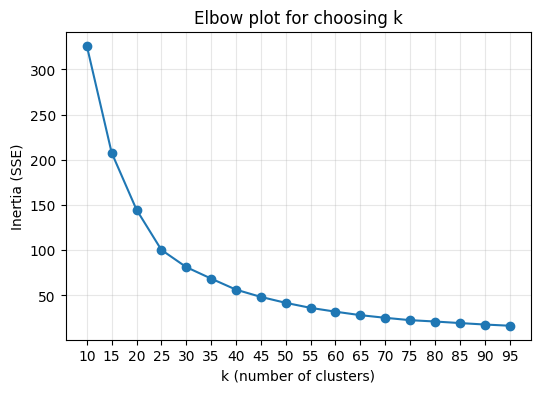

In [7]:
ks = list(range(10, 100, 5))
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(train_coords)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(ks, inertias, marker='o')
plt.xticks(ks)
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow plot for choosing k')
plt.grid(True, alpha=0.3)
plt.show()


In [8]:
N_CLUSTERS = 50  # adjust after inspecting the elbow plot
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(train_coords)
print(f'Train inertia: {kmeans.inertia_:.4f}')


Train inertia: 41.8042


In [9]:
def describe_split(coords, name):
    if len(coords) == 0:
        print(f'{name}: no coords')
        return
    labels = kmeans.predict(coords)
    unique, counts = np.unique(labels, return_counts=True)
    summary = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)
    print(f'--- {name} ---')
    total = counts.sum()
    for cid, cnt in summary[:10]:
        pct = 100.0 * cnt / total
        print(f'cluster {cid:02d}: {cnt} pts ({pct:.1f}%)')

describe_split(train_coords, 'train')
describe_split(val_coords, 'val')
describe_split(test_coords, 'test')


--- train ---
cluster 07: 4029 pts (8.7%)
cluster 11: 2838 pts (6.2%)
cluster 10: 2609 pts (5.7%)
cluster 30: 2546 pts (5.5%)
cluster 22: 2257 pts (4.9%)
cluster 47: 2023 pts (4.4%)
cluster 31: 1780 pts (3.9%)
cluster 49: 1293 pts (2.8%)
cluster 29: 1290 pts (2.8%)
cluster 42: 1206 pts (2.6%)
--- val ---
cluster 15: 3421 pts (7.8%)
cluster 26: 2304 pts (5.2%)
cluster 33: 2037 pts (4.6%)
cluster 32: 1706 pts (3.9%)
cluster 36: 1679 pts (3.8%)
cluster 05: 1566 pts (3.6%)
cluster 07: 1460 pts (3.3%)
cluster 17: 1343 pts (3.1%)
cluster 41: 1329 pts (3.0%)
cluster 21: 1297 pts (2.9%)
--- test ---
cluster 15: 4411 pts (10.1%)
cluster 26: 2349 pts (5.4%)
cluster 07: 1754 pts (4.0%)
cluster 32: 1666 pts (3.8%)
cluster 33: 1658 pts (3.8%)
cluster 39: 1596 pts (3.6%)
cluster 16: 1549 pts (3.5%)
cluster 22: 1425 pts (3.3%)
cluster 44: 1302 pts (3.0%)
cluster 01: 1201 pts (2.7%)


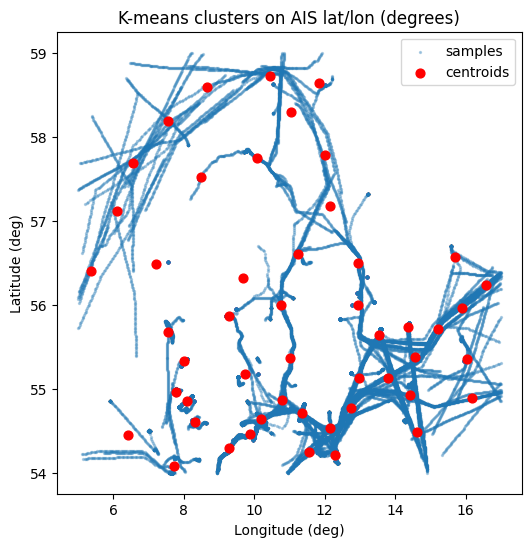

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(train_coords_deg[:, 1], train_coords_deg[:, 0], s=2, alpha=0.3, label='samples')
centers_deg = denormalize_coords(kmeans.cluster_centers_)
plt.scatter(centers_deg[:, 1], centers_deg[:, 0], c='red', s=40, label='centroids')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('K-means clusters on AIS lat/lon (degrees)')
plt.legend()
plt.show()


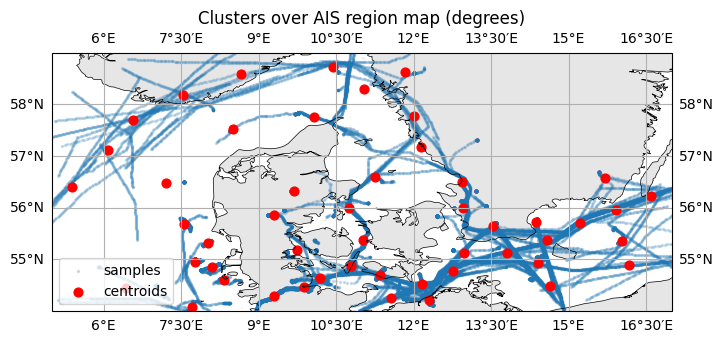

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.9')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.scatter(train_coords_deg[:, 1], train_coords_deg[:, 0], s=2, alpha=0.2, transform=ccrs.PlateCarree(), label='samples')
centers_deg = denormalize_coords(kmeans.cluster_centers_)
ax.scatter(centers_deg[:, 1], centers_deg[:, 0], c='red', s=40, transform=ccrs.PlateCarree(), label='centroids')
ax.set_title('Clusters over AIS region map (degrees)')
ax.legend(loc='lower left')
plt.show()


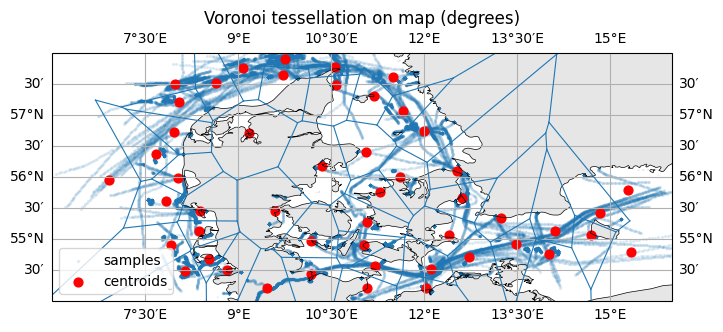

In [11]:
centers_deg = denormalize_coords(kmeans.cluster_centers_)
centers_lon_lat = np.stack([centers_deg[:, 1], centers_deg[:, 0]], axis=1)
vor = Voronoi(centers_lon_lat)
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.9')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
for simplex in vor.ridge_vertices:
    if -1 in simplex:
        continue
    pts = vor.vertices[simplex]
    ax.plot(pts[:, 0], pts[:, 1], color='tab:blue', linewidth=0.8, transform=ccrs.PlateCarree())
ax.scatter(train_coords_deg[:, 1], train_coords_deg[:, 0], s=2, alpha=0.1, transform=ccrs.PlateCarree(), label='samples')
ax.scatter(centers_lon_lat[:, 0], centers_lon_lat[:, 1], c='red', s=40, transform=ccrs.PlateCarree(), label='centroids')
ax.set_title('Voronoi tessellation on map (degrees)')
ax.legend(loc='lower left')
plt.show()


## Notes
- Lat/lon are denormalized back to physical degrees using the preprocessing bounds before visualization or mapping.
- Use the elbow plot to guide the `N_CLUSTERS` choice, then update `N_CLUSTERS` and re-run the fitting/visualization cells.
- The Cartopy map provides a quick geographic context; ensure `cartopy` and its Natural Earth assets are installed in your environment.
